In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, LeakyReLU, Conv2D, Conv2DTranspose, BatchNormalization, ReLU, Activation
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from utils.callbacks import SaveImages

2024-12-06 21:57:42.681007: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def Generator(seed_size):
    input = Input(shape=(seed_size,))

    x = Dense(7 * 7 * 256)(input) # 100 -> 7x7x256 = 12544
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Reshape((7, 7, 256))(x) # 12544 -> 7x7x256

    x = Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding="same")(x) # 7x7x256 -> 7x7x128
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding="same")(x) # 7x7x128 -> 14x14x64
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), padding="same")(x) # 14x14x64 -> 28x28x1
    output = Activation("tanh")(x) # [-1, 1]

    return Model(input, output, name="Generator")

def Discriminator(image_shape):
    input = Input(shape=image_shape)

    x = Conv2D(64, (5, 5), strides=(2, 2), padding="same")(input)  # 28x28x1 -> 14x14x64
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding="same")(x) # 14x14x64 -> 7x7x128
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x) # 7x7x128 -> 6272

    x = Dense(1)(x) # 6272 -> 1
    output = Activation("sigmoid")(x) # [0, 1]

    return Model(input, output, name="Discriminator")

In [3]:
# Custom GAN Model
class GAN(tf.keras.Model):
    def __init__(self, generator, discriminator, seed_size):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.seed_size = seed_size

        self.generator_loss_tracker = tf.keras.metrics.Mean(name="generator_loss")
        self.discriminator_loss_tracker = tf.keras.metrics.Mean(name="discriminator_loss")

    def compile(self, generator_optimizer, discriminator_optimizer, loss_fn):
        super(GAN, self).compile()
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [
            self.generator_loss_tracker,
            self.discriminator_loss_tracker
        ]

    def generator_loss(self, fake_output):
        return self.loss_fn(tf.ones_like(fake_output), fake_output) # Means how well the generator fooled the discriminator

    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.loss_fn(tf.ones_like(real_output), real_output) 
        fake_loss = self.loss_fn(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss
    
    @tf.function
    def train_step(self, data):
        batch_size = tf.shape(data)[0]

        seed = tf.random.normal(shape=(batch_size, self.seed_size))

        with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
            generated_image = self.generator(seed, training = True)

            real_output = self.discriminator(data, training = True)
            fake_output = self.discriminator(generated_image, training = True) 

            generator_loss = self.generator_loss(fake_output)
            discriminator_loss = self.discriminator_loss(real_output, fake_output)

        generator_grad = generator_tape.gradient(generator_loss, self.generator.trainable_variables)
        discriminator_grad = discriminator_tape.gradient(discriminator_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(generator_grad, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(discriminator_grad, self.discriminator.trainable_variables))

        self.generator_loss_tracker.update_state(generator_loss)
        self.discriminator_loss_tracker.update_state(discriminator_loss)

        return {
            "generator_loss": self.generator_loss_tracker.result(),
            "discriminator_loss": self.discriminator_loss_tracker.result()
        }


    @tf.function
    def test_step(self, data):
        batch_size = tf.shape(data)[0]

        seed = tf.random.normal(shape=(batch_size, self.seed_size))

        generated_image = self.generator(seed, training = False)

        real_output = self.discriminator(data, training = False)
        fake_output = self.discriminator(generated_image, training = False) 

        generator_loss = self.generator_loss(fake_output)
        discriminator_loss = self.discriminator_loss(real_output, fake_output)

        self.generator_loss_tracker.update_state(generator_loss)
        self.discriminator_loss_tracker.update_state(discriminator_loss)

        return {
            "generator_loss": self.generator_loss_tracker.result(),
            "discriminator_loss": self.discriminator_loss_tracker.result()
        }
    
    @tf.function 
    def call(self, inputs):
        image  = self.generator(inputs, training=False)
        score = self.discriminator(image, training=False)

        return image, score

In [4]:
# Constants
IMAGE_SHAPE = (28, 28, 1)
BATCH_SIZE = 100
EPOCHS = 25
SEED_SIZE = 100

CALLBACK_NUM_ROWS = 4
CALLBACK_NUM_COLS = 7
CALLBACK_MARGIN = 16

CALLBACK_FIXED_SEED = tf.random.normal(shape=(CALLBACK_NUM_ROWS * CALLBACK_NUM_COLS, SEED_SIZE))
IMAGE_FIXED_SEED = tf.random.normal(shape=(10, SEED_SIZE))

GAN_WEIGHTS_PATH = "mnist_gan.weights.h5"

In [5]:
# Load and preprocess MNIST data
(x_train, _), (_, _) = mnist.load_data()

train_ds = x_train[:50000] # Train on 50,000 examples
val_ds = x_train[50000:] # Validate on 10,000 examples

TRAIN_BUFFER_SIZE = train_ds.shape[0]
VAL_BUFFER_SIZE = val_ds.shape[0]

train_ds = train_ds.reshape(train_ds.shape[0], 28, 28, 1).astype("float32")
val_ds = val_ds.reshape(val_ds.shape[0], 28, 28, 1).astype("float32")

train_ds = (train_ds / 127.5) - 1.0
val_ds = (val_ds / 127.5) - 1.0

train_ds = tf.data.Dataset.from_tensor_slices(train_ds).shuffle(TRAIN_BUFFER_SIZE).batch(BATCH_SIZE)
val_ds = tf.data.Dataset.from_tensor_slices(val_ds).shuffle(VAL_BUFFER_SIZE).batch(BATCH_SIZE)

In [6]:
# Build generator and discriminator
generator = Generator(SEED_SIZE)
discriminator = Discriminator(IMAGE_SHAPE)

generator.build(input_shape=(None, SEED_SIZE))
discriminator.build(input_shape=(None, 28, 28, 1))

gan = GAN(generator, discriminator, SEED_SIZE)
gan.build(input_shape=(None, SEED_SIZE))

# load weights if file exists
if tf.io.gfile.exists(GAN_WEIGHTS_PATH):
  gan.load_weights(GAN_WEIGHTS_PATH)
  print("Loaded weights from file")

gan.compile(
  generator_optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
  discriminator_optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
  loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=False)
)

gan.summary()
# gan.generator.summary()
# gan.discriminator.summary()

Loaded weights from file


Model: "gan"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Generator (Functional)          │ (None, 28, 28, 1)      │     2,343,681 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Discriminator (Functional)      │ (None, 1)              │       212,865 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,556,546 (9.75 MB)

 Trainable params: 2,531,074 (9.66 MB)

 Non-trainable params: 25,472 (99.50 KB)

In [7]:
# Train the GAN model
# gan.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=101,
#     batch_size=BATCH_SIZE,
#     initial_epoch=100, # should be last_epoch_saved + 1 or 0 of no weights saved
#     callbacks=[
#         CSVLogger("mnist_gan.csv", append=True),
#         ModelCheckpoint(GAN_WEIGHTS_PATH, monitor="generator_loss", mode='min', save_best_only=True, save_weights_only=True),
#         SaveImages(noise=CALLBACK_FIXED_SEED, num_rows=CALLBACK_NUM_ROWS, num_cols=CALLBACK_NUM_COLS, margin=CALLBACK_MARGIN)
#     ]
# )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


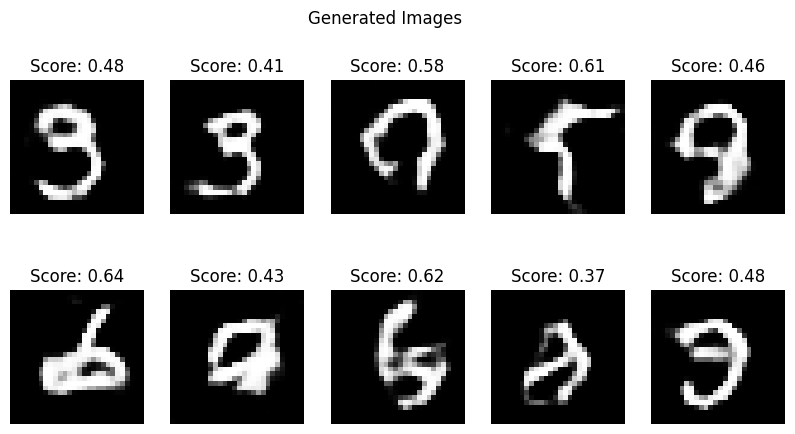

In [8]:
image, score = gan.predict(IMAGE_FIXED_SEED)

# show 10 images with the discriminator scores
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
fig.suptitle("Generated Images")
for i in range(10):
    row = i // 5
    col = i % 5
    axs[row, col].imshow((image[i, :, :, 0] + 1.0) * 127.5, cmap="gray")
    axs[row, col].axis("off")
    axs[row, col].set_title(f"Score: {score[i][0]:.2f}")

Text(0.5, 1.0, 'Validation Loss')

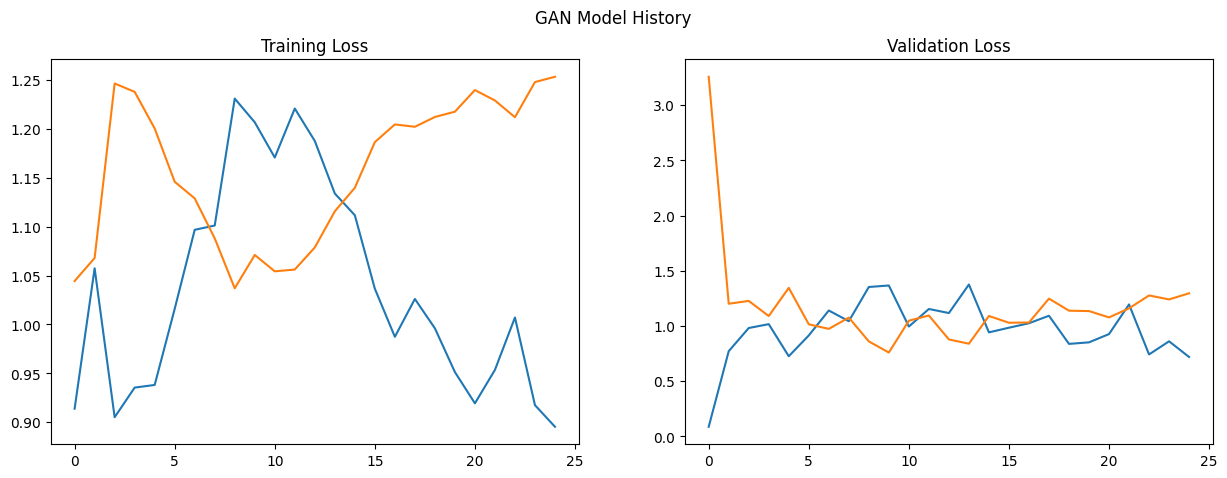

In [9]:
# plot history of the model on graph
import pandas as pd

def read_logs(log_path):
    df = pd.read_csv(log_path)
    return df

df = read_logs("mnist_gan.csv")

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("GAN Model History")
axs[0].plot(df["generator_loss"], label="generator_loss")
axs[0].plot(df["discriminator_loss"], label="discriminator_loss")
axs[0].set_title("Training Loss")

axs[1].plot(df["val_generator_loss"], label="val_generator_loss")
axs[1].plot(df["val_discriminator_loss"], label="val_discriminator_loss")
axs[1].set_title("Validation Loss")